<a href="https://colab.research.google.com/github/AdrianGuel/StochasticProcesses/blob/main/CubicvsLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install libraries
!pip install torchsde
!pip install KDEpy

In [ ]:
# Import methods
import torch
torch.cuda.empty_cache()
from torch import nn
%matplotlib inline
import matplotlib.pyplot as plt
import torchsde
from scipy.integrate import odeint
import numpy as np
from KDEpy import FFTKDE
from scipy.signal import savgol_filter
from scipy import stats
from mpl_toolkits import mplot3d
import torch.nn.functional as F
from scipy.io import savemat

In [ ]:
# Laplace Assumption of a simple cubc stochastic differential equation
def f(y, t, gamma, Dx):
    return np.array([-gamma*y[0]**3-0.5*gamma*6*y[0]*y[1],-6*gamma*y[1]*(y[0]**2)+2*Dx])
#Parameters
mu0, gamma, Dx, beta0, t_size = 5, 0.01, 0.01**2, 0.01, 10**3
x_size=10**3
gpu = torch.device('cuda')
x = np.linspace(0,6, x_size)
t = np.linspace(0, 3, t_size)
f0 = np.array([mu0, beta0])
M = odeint(f, f0, t, args=(gamma, Dx))
#Information Rate
dM=-gamma*M[:,0]**3-0.5*gamma*6*M[:,0]*M[:,1]
dS=-6*gamma*M[:,1]*(M[:,0]**2)+2*Dx
G2=(dM**2)/M[:,1]+0.5*(dS/M[:,1])**2
#Gaussian density estimation
pla= torch.zeros([x_size, t_size])
pla=pla.to(gpu)
for i in range(0,t_size):
  pla[:,i]=torch.tensor(stats.norm.pdf(x, M[i,0], np.sqrt(M[i,1])))

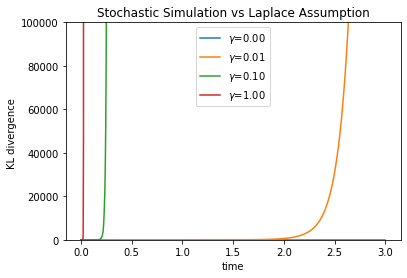

In [ ]:
#Stochastic simulation and kernel density estimation comparison SSvsLA changing gamma
class SDE(nn.Module):

    def __init__(self,gamma,D):
        super().__init__()
        self.thetaf = nn.Parameter(torch.tensor(gamma), requires_grad=False)  # Scalar parameter.
        self.thetag = nn.Parameter(torch.tensor(D), requires_grad=False)
        self.noise_type = "diagonal"
        self.sde_type = "ito"
    
    def f(self, t, y):
        return -self.thetaf * y**3
    
    def g(self,t,y):
        return self.thetag+ torch.sigmoid(y)*0

batch_size, state_size, t_size = 10**6, 1, 10**3
sde = SDE(gamma,np.sqrt(Dx))
ts = torch.linspace(0, 3, t_size)
y0 = torch.normal(mu0, np.sqrt(beta0), size=(batch_size, state_size))
g=[0.001,0.01,0.1,1]
KL= torch.zeros([len(g),t_size])
for k in range(0,len(g)):
  torch.cuda.empty_cache()
  sde = SDE(g[k],np.sqrt(Dx)).to(gpu)
  ts = ts.to(gpu)
  y0 = y0.to(gpu)
  pdf= torch.zeros([x_size, t_size])
  pdf=pdf.to(gpu)
  #LA
  M = odeint(f, f0, t, args=(g[k], Dx))
  #Solution on GPU of the stochastic differential equation
  with torch.no_grad():
      ys = torchsde.sdeint(sde, y0, ts, method='srk',adaptive=True)
  samples = ys.squeeze().t().cpu()
  #Kernel density estimation
  for i in range(0,t_size):
    y = FFTKDE(kernel='gaussian', bw='silverman').fit(samples[:,i].cpu().detach().numpy()).evaluate(x)
    pdf[:,i] = torch.from_numpy(y)
    pla[:,i]=torch.tensor(stats.norm.pdf(x, M[i,0], np.sqrt(M[i,1])))
    KL[k,i]=F.kl_div(pla[:,i],pdf[:,i].exp(),reduction='batchmean')
for i in range(0,len(g)):
  txt = "$\gamma$={:.2f}".format(g[i])
  plt.plot(t,KL[i,:],label=txt)
plt.ylim([0, 1e5])
plt.title('Stochastic Simulation vs Laplace Assumption') 
plt.xlabel('time')
plt.ylabel('KL divergence ')
plt.legend(loc="upper center")
plt.show()
#save to plot in MATLAB
mdict = {"KL_div" : KL.cpu().detach().numpy(), "t": t, "gamma": g, "D": Dx}
savemat("SSvsLAg.mat", mdict)

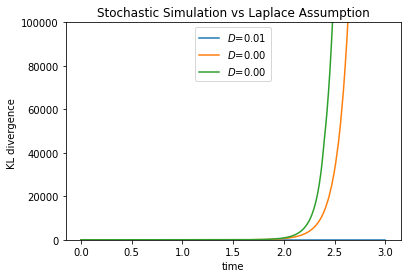

In [ ]:
#Stochastic simulation and kernel density estimation comparison SSvsLA changing D
Di=[0.1**2,0.01**2,0.001**2]
KL= torch.zeros([len(Di),t_size])
for k in range(0,len(Di)):
  torch.cuda.empty_cache()
  sde = SDE(gamma,np.sqrt(Di[k])).to(gpu)
  ts = ts.to(gpu)
  y0 = y0.to(gpu)
  pdf= torch.zeros([x_size, t_size])
  pdf=pdf.to(gpu)
  #LA
  M = odeint(f, f0, t, args=(gamma, Di[k]))
  #Solution on GPU of the stochastic differential equation
  with torch.no_grad():
      ys = torchsde.sdeint(sde, y0, ts, method='srk',adaptive=True)
  samples = ys.squeeze().t().cpu()
  #Kernel density estimation
  for i in range(0,t_size):
    y = FFTKDE(kernel='gaussian', bw='silverman').fit(samples[:,i].cpu().detach().numpy()).evaluate(x)
    pdf[:,i] = torch.from_numpy(y)
    pla[:,i]=torch.tensor(stats.norm.pdf(x, M[i,0], np.sqrt(M[i,1])))
    KL[k,i]=F.kl_div(pla[:,i],pdf[:,i].exp(),reduction='batchmean')
for i in range(0,len(Di)):
  txt = "$D$={:.2f}".format(Di[i])
  plt.plot(t,KL[i,:],label=txt)
plt.ylim([0, 1e5])
plt.title('Stochastic Simulation vs Laplace Assumption') 
plt.xlabel('time')
plt.ylabel('KL divergence ')
plt.legend(loc="upper center")
plt.show()    

#save to plot in MATLAB
mdict = {"KL_div" : KL.cpu().detach().numpy(), "t": t, "gamma": gamma, "D": Di}
savemat("SSvsLAD.mat", mdict)